In [1]:
import requests
import json
import datetime
import pandas as pd
import numpy as np

In [2]:
USERNAME ='OOIAPI-9N9UMLHV9W5GOP'
TOKEN= 'SJN6HXHH116OZ8'

In [7]:
# define your inputs and starting time

refdes_streams = '/Users/knuth/Documents/ooi/repos/github/ooi_stats/botpt_streams.csv'
begin_time_set = datetime.date(2016, 7, 10)

In [8]:
# wrangling

# request only parameter 7 (time)
parameter = '7' 

# read in csv (for now)
refdes_streams_df = pd.read_csv(refdes_streams, parse_dates=True) # read in csv (for now).

# prepare time stamp related stuff
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

# create some empty lists as inputs for your final data frame output
ref_des_list = []
stream_list = []
timestamp_list = []

In [9]:
%%time

# interate over reference designators, delivery methods and streams

for index, row in refdes_streams_df.iterrows():
    ref_des =  row['ref_des']
    stream = row['stream']
    delivery_method = row['delivery_method']
    
    begin_time = begin_time_set
    begin_time_str = begin_time.strftime('%Y-%m-%dT%H:%M:%S.000Z')
    end_time = begin_time + datetime.timedelta(seconds=86400)
    end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%S.000Z')

    # print ref_des,stream,delivery_method
    
    # while begin_time < datetime.datetime.now().date(): # use this to run from begin time until present
    for i in range(5): # use for testing
        
        try:        
            response = requests.get('https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'+ref_des[:8]+'/'+ref_des[9:14]+'/'+ref_des[15:27]+'/'+delivery_method+'/'+stream+'?beginDT='+begin_time_str+'&endDT='+end_time_str+'&limit=1000&parameters='+parameter, auth=(USERNAME, TOKEN))
            data = response.json()
            timestamp = data[0]['time']
            timestamp = datetime.datetime.utcfromtimestamp(timestamp - ntp_delta).replace(microsecond=0)
            timestamp = timestamp.date()

            # print timestamp

            ref_des_list.append(ref_des)
            stream_list.append(stream)
            timestamp_list.append(timestamp)

        except:
            data = response.json()
            # print "\n From", begin_time_str, end_time_str, ":"
            # print data['status']


        # move to next day
        begin_time = begin_time + datetime.timedelta(seconds=86400)
        begin_time_str = begin_time.strftime('%Y-%m-%dT%H:%M:%S.000Z')
        end_time = end_time + datetime.timedelta(seconds=86400)
        end_time_str = end_time.strftime('%Y-%m-%dT%H:%M:%S.000Z')

CPU times: user 2.41 s, sys: 127 ms, total: 2.54 s
Wall time: 1min 14s


In [10]:
# convert lists to data frame
data_dict = {
    'refdes':ref_des_list,
    'stream':stream_list,
    'timestamp':timestamp_list}
ooi_data = pd.DataFrame(data_dict, columns = ['refdes', 'stream', 'timestamp'])

In [11]:
# collapse by unique ref_des and day with data
ooi_data = ooi_data.drop('stream', axis = 1)
ooi_data = ooi_data.drop_duplicates()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [13]:
yticks=[]

for index, row in ooi_data.iterrows():
    yticks.append(row["refdes"])
    
yticks = pd.unique(yticks)
yticks = yticks[::-1]
y = np.arange(len(yticks))
counter = -1

In [14]:
for x in y:
    print yticks[counter]
    for index, row in ooi_data.iterrows():
        if yticks[counter] == row["refdes"]:
            StartTime = row['timestamp']
            EndTime = row['timestamp'] + datetime.timedelta(seconds=86400)
            stream_time = np.array([StartTime,EndTime])
            stream_shape = np.full((stream_time.shape),y[counter])
            plt.plot(stream_time, stream_shape, linewidth=10, color='blue')
    counter = counter -1

RS03CCAL-MJ03F-05-BOTPTA301
RS03ECAL-MJ03E-06-BOTPTA302
RS03INT2-MJ03D-06-BOTPTA303


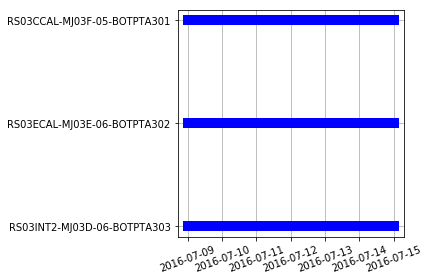

In [15]:
plt.yticks(y, yticks)      
plt.xticks(rotation=20)
plt.tight_layout()
plt.grid()
plt.show()